# <center> Emotional Analysis Implementation using GloVe

In [4]:
#import python packages
import pandas as pd
import numpy as np
import re

#import graph packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as b

#NLP packages
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer

#Model packages
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Flatten, GlobalMaxPool1D, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
#import dataset
dataset = pd.read_csv('data/text_emotion.csv')
dataset.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


### Data Cleaning

In [70]:
#Clean dataset
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub('\W',' ', txt)#Remove non words
    txt = re.sub('\d',' ', txt)#Remove digits
    txt = re.sub('\s+[a-z]\s+',' ', txt) #Remove single letters
    txt = re.sub('\s+',' ', txt) #Remove multi space
    txt = re.sub('^\s','', txt)#Remove space at start of text
    txt = re.sub('$\s','', txt)#Remove space at end of text
    txt = txt.split()
    txt = [_eachword for _eachword in txt if _eachword not in stop_words]
    txt = [WordNetLemmatizer().lemmatize(_eachword) for _eachword in txt]
    return ' '.join(txt)

In [71]:
dataset['cleaned_review'] = dataset['content'].apply(lambda x: clean_text(x))
dataset.head()

,tweet_id,sentiment,author,content,encoded_sentiment,cleaned_review
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,2,tiffanylue know listenin bad habit earlier sta...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,10,layin bed headache ughhhh waitin call
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,10,funeral ceremony gloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,3,want hang friend soon
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,8,dannycastillo want trade someone houston ticke...


### Encode the sentiment to values

In [5]:
le = LabelEncoder()
dataset['encoded_sentiment'] = le.fit_transform(list(dataset['sentiment'].values))
dataset['encoded_sentiment'].head()

0     2
1    10
2    10
3     3
4     8
Name: encoded_sentiment, dtype: int64

In [6]:
#Review the encoded values
dataset.groupby(['sentiment', 'encoded_sentiment'])['content'].count()

sentiment   encoded_sentiment
anger       0                     110
boredom     1                     179
empty       2                     827
enthusiasm  3                     759
fun         4                    1776
happiness   5                    5209
hate        6                    1323
love        7                    3842
neutral     8                    8638
relief      9                    1526
sadness     10                   5165
surprise    11                   2187
worry       12                   8459
Name: content, dtype: int64

In [16]:
#Create a dict for encoded sentiment
x = dataset.groupby(['sentiment', 'encoded_sentiment'])['content'].count()
x = x.index
dict_emotion={}
for _each in x:
    dict_emotion[_each[0]] = _each[1]
dict_emotion

{'anger': 0,
 'boredom': 1,
 'empty': 2,
 'enthusiasm': 3,
 'fun': 4,
 'happiness': 5,
 'hate': 6,
 'love': 7,
 'neutral': 8,
 'relief': 9,
 'sadness': 10,
 'surprise': 11,
 'worry': 12}

### Create Word2Vect from GloVe

In [20]:
print('Building word vector...', end='\r')
word2vec = {}
glove = open('Glove/glove.6B/glove.6B.50d.txt', encoding='utf-8')
for _eachline in glove:
    _eachline = _eachline.split()
    _word = _eachline[0]
    _vector = np.asarray(_eachline[1:], dtype='float32')
    if _word is not None:
        word2vec[_word] = _vector
glove.close()        

print('Building word vector... Completed')
print('Total word vectors: ', len(word2vec))

Building word vector... Completed
Total word vectors:  400000


### Build Tokenizer to transform Datasets

In [72]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(dataset['cleaned_review'].values)

In [73]:
word2idx = tokenizer.word_index
print('Tokenizer Vocab Length: ', len(word2idx)+1)

Tokenizer Vocab Length:  43036


### Find Average and Max length of dataset

In [74]:
print('Average length of Review: ', dataset['content'].apply(lambda x: len(x.split())).mean())
print('Max length of Review: ', dataset['content'].apply(lambda x: len(x.split())).max())

Average length of Review:  13.216875
Max length of Review:  34


### Split data into training and test set

In [75]:
X_train, X_test, y_train, y_test = train_test_split(dataset['cleaned_review'].values, 
                                                    dataset['encoded_sentiment'], 
                                                    test_size=0.3, random_state=42)
print('Length of Training Set: ', len(X_train))
print('Length of Test Set: ', len(X_test))

Length of Training Set:  28000
Length of Test Set:  12000


In [76]:
#Tokenize Training and Test dataset
training_dataset = tokenizer.texts_to_sequences(X_train)
testing_dataset = tokenizer.texts_to_sequences(X_test)

In [77]:
#Lets pad the dataset to equal the length of sentence
training_dataset = pad_sequences(training_dataset, maxlen=40, padding='post')
testing_dataset = pad_sequences(testing_dataset, maxlen=40, padding='post')

### Build the Embedding Matrix from words in dataset referencing in Glove

In [78]:
embedding_matrix = np.zeros((30000, 50)) #30000 - Total words vocab, 50 -Embedding size from glove

for _word, _idx in word2idx.items():
    if _idx < 30000 :
        embed_vector = word2vec.get(_word)
        if embed_vector is not None:
            embedding_matrix[_idx] = embed_vector
print('Embedding matrix created.')            

Embedding matrix created.


In [79]:
embedding_matrix.shape

(30000, 50)

In [80]:
embedding_matrix[22]

array([ 0.43360001,  1.07270002, -0.6196    , -0.80678999,  1.25189996,
        1.37670004, -0.93532997,  0.76087999, -0.0056654 , -0.063649  ,
        0.30296999,  0.52401   ,  0.2843    , -0.38161999,  0.98796999,
        0.093184  , -1.14639997,  0.070523  ,  0.58012003,  0.50643998,
       -0.24026   ,  1.73440003,  0.020735  ,  0.43704   ,  1.2148    ,
       -2.24830008, -0.41168001, -0.24922   ,  0.31224999, -0.49463999,
        2.04410005, -0.012111  , -0.19555999,  0.085665  ,  0.27682   ,
        0.015702  ,  0.0067683 ,  0.12759   ,  0.87007999, -0.40641001,
       -0.21056999,  0.41650999, -0.021812  , -0.53649002,  0.54095   ,
       -0.43441999, -0.52489001, -2.02769995,  0.13135999,  0.11704   ])

### LSTM Model Building

In [157]:
model = Sequential()

In [158]:
model.add(Embedding(30000, 50, weights=[embedding_matrix], trainable=False, input_length=40))

In [159]:
model.add(Bidirectional(LSTM(32, return_sequences=True)))

In [160]:
model.add(LSTM(64, return_sequences=True))

In [161]:
model.add(GlobalMaxPool1D())

In [162]:
model.add(Dropout(0.05))

In [163]:
model.add(Dense(128, activation='relu'))

In [164]:
model.add(Dense(len(dict_emotion), activation='softmax'))

In [165]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [166]:
mcheckpt = ModelCheckpoint('EmotionalAnalysis_0227.hdf5', monitor='val_acc', save_best_only=True)

In [167]:
estopping = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=3)

In [168]:
history = model.fit(training_dataset, y_train, epochs=50, batch_size=32, 
                    validation_data = (testing_dataset, y_test), callbacks=[mcheckpt, estopping], verbose=1);

Train on 28000 samples, validate on 12000 samples
Epoch 1/50
28000/28000 [==============================] - 71s 3ms/step - loss: 2.2498 - acc: 0.2261 - val_loss: 2.1580 - val_acc: 0.2532
Epoch 2/50
28000/28000 [==============================] - 68s 2ms/step - loss: 2.1434 - acc: 0.2524 - val_loss: 2.1431 - val_acc: 0.2510
Epoch 3/50
28000/28000 [==============================] - 65s 2ms/step - loss: 2.1321 - acc: 0.2574 - val_loss: 2.1354 - val_acc: 0.2558
Epoch 4/50
28000/28000 [==============================] - 64s 2ms/step - loss: 2.1251 - acc: 0.2582 - val_loss: 2.1282 - val_acc: 0.2555


### Plotting the model training

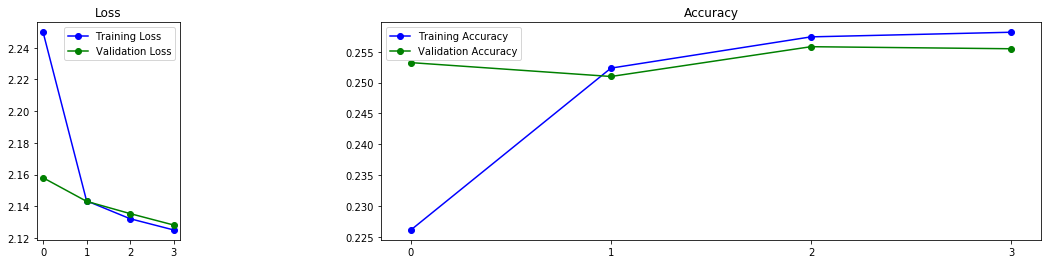

In [169]:
grid = plt.GridSpec(4,6)
plt.subplots(figsize=(18,4))

#plot 1
plt.subplot(grid[:,:1])
plt.plot(history.epoch, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], 'go-', label='Validation Loss')
plt.xticks(range(4))
plt.legend(loc='best')
plt.title('Loss')

#Plot 2
plt.subplot(grid[:,2:])
plt.plot(history.epoch, history.history['acc'], 'bo-', label='Training Accuracy')
plt.plot(history.epoch, history.history['val_acc'], 'go-', label='Validation Accuracy')
plt.xticks(history.epoch)
plt.title('Accuracy')
plt.legend(loc='best')
plt.show();

---

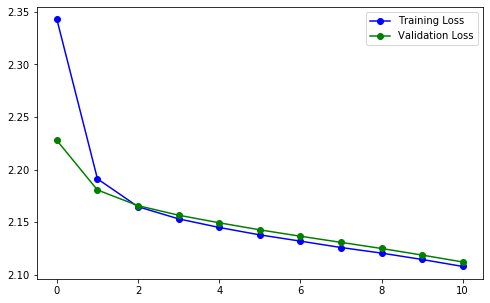

In [95]:
plt.figure(figsize=(8, 5))
plt.plot(history.epoch, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], 'go-', label='Validation Loss')
plt.legend(loc='best')
plt.show();

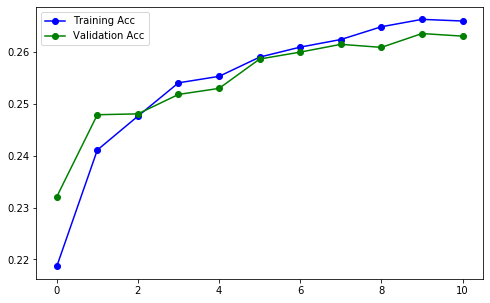

In [97]:
plt.figure(figsize=(8, 5))
plt.plot(history.epoch, history.history['acc'], 'bo-', label='Training Acc')
plt.plot(history.epoch, history.history['val_acc'], 'go-', label='Validation Acc')
plt.legend(loc='best')
plt.show();